# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/My Drive/CS444/assignment3_starter/assignment3_part1/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/CS444/assignment3_starter/assignment3_part1/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS444/assignment3_starter/assignment3_part1


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
      return img
    elif rot == 1:
      return transforms.functional.rotate(img, 90)
    elif rot == 2:
      return transforms.functional.rotate(img, 180)
    elif rot == 3:
      return transforms.functional.rotate(img, 270)
    else:
      raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

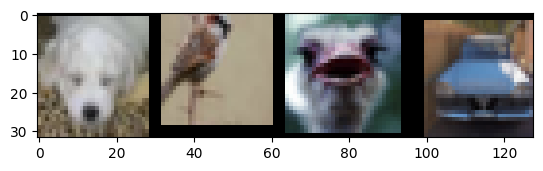

Class labels:  dog   bird  bird  car  


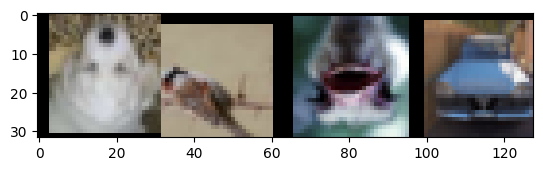

Rotation labels:  180   90    180   0    


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.argmax(outputs, axis =1 )
            total += labels.size(0)

            avg_test_loss += criterion(outputs, labels)  / len(testloader)
            correct += (predicted == labels).sum().item()
    print('TESTING:')

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
#
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 1e-3, params= net.parameters())


In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels

            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize

            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            #

            # TODO: Get predicted results
            predicted = torch.argmax(outputs, axis =1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=15, init_lr=0.001, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), 'Resnet_03_26_15_41.pt')

[1,   100] loss: 1.277 acc: 42.62 time: 19.18
[1,   200] loss: 1.136 acc: 49.64 time: 10.06
[1,   300] loss: 1.105 acc: 52.20 time: 8.28
TESTING:
Accuracy of the network on the 10000 test images: 55.77 %
Average loss on the 10000 test images: 1.031
[2,   100] loss: 1.054 acc: 54.88 time: 9.54
[2,   200] loss: 1.043 acc: 55.61 time: 9.07
[2,   300] loss: 1.006 acc: 57.39 time: 7.98
TESTING:
Accuracy of the network on the 10000 test images: 59.22 %
Average loss on the 10000 test images: 0.998
[3,   100] loss: 0.981 acc: 59.04 time: 9.75
[3,   200] loss: 0.969 acc: 59.45 time: 7.78
[3,   300] loss: 0.946 acc: 60.30 time: 9.36
TESTING:
Accuracy of the network on the 10000 test images: 61.00 %
Average loss on the 10000 test images: 0.972
[4,   100] loss: 0.929 acc: 60.91 time: 7.96
[4,   200] loss: 0.926 acc: 61.64 time: 9.38
[4,   300] loss: 0.907 acc: 62.44 time: 9.40
TESTING:
Accuracy of the network on the 10000 test images: 62.89 %
Average loss on the 10000 test images: 0.886
[5,   100]

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
net = resnet18(num_classes=4)
net.load_state_dict(torch.load('Resnet_03_26_15_41.pt'))

<All keys matched successfully>

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for param in net.parameters():
  param.requires_grad = False

for param in net.layer4.parameters():
  param.requires_grad = True



num_ftrs  = net.fc.in_features
net.fc    = nn.Linear(num_ftrs, 10)

for param in net.fc.parameters():
  param.requires_grad = True

net = net.to(device)


In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.001, task='classification')


[1,   100] loss: 1.685 acc: 38.38 time: 8.16
[1,   200] loss: 1.396 acc: 48.73 time: 7.14
[1,   300] loss: 1.315 acc: 51.46 time: 8.17
TESTING:
Accuracy of the network on the 10000 test images: 54.75 %
Average loss on the 10000 test images: 1.267
[2,   100] loss: 1.253 acc: 54.53 time: 7.43
[2,   200] loss: 1.241 acc: 55.20 time: 8.24
[2,   300] loss: 1.230 acc: 55.09 time: 6.83
TESTING:
Accuracy of the network on the 10000 test images: 57.82 %
Average loss on the 10000 test images: 1.179
[3,   100] loss: 1.188 acc: 56.77 time: 8.39
[3,   200] loss: 1.167 acc: 58.12 time: 7.04
[3,   300] loss: 1.165 acc: 57.93 time: 9.68
TESTING:
Accuracy of the network on the 10000 test images: 59.66 %
Average loss on the 10000 test images: 1.139
[4,   100] loss: 1.146 acc: 58.86 time: 7.00
[4,   200] loss: 1.136 acc: 59.25 time: 8.35
[4,   300] loss: 1.135 acc: 59.03 time: 6.78
TESTING:
Accuracy of the network on the 10000 test images: 60.14 %
Average loss on the 10000 test images: 1.118
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
net = resnet18(num_classes  = 10)
for param in net.parameters():
  param= torch.rand(size = param.size())

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
for param in net.parameters():
  param.requires_grad = False

for param in net.layer4.parameters():
  param.requires_grad = True

for param in net.fc.parameters():
  param.requires_grad = True

net = net.to(device)

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 1e-3, params= net.parameters())

In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=5, init_lr=0.001, task='classification')

[1,   100] loss: 2.037 acc: 27.02 time: 14.79
[1,   200] loss: 1.882 acc: 31.62 time: 8.81
[1,   300] loss: 1.863 acc: 32.56 time: 6.90
TESTING:
Accuracy of the network on the 10000 test images: 37.44 %
Average loss on the 10000 test images: 1.735
[2,   100] loss: 1.802 acc: 35.16 time: 8.66
[2,   200] loss: 1.776 acc: 35.98 time: 9.05
[2,   300] loss: 1.772 acc: 35.91 time: 8.91
TESTING:
Accuracy of the network on the 10000 test images: 39.38 %
Average loss on the 10000 test images: 1.672
[3,   100] loss: 1.732 acc: 37.80 time: 7.37
[3,   200] loss: 1.731 acc: 37.75 time: 8.92
[3,   300] loss: 1.723 acc: 37.73 time: 7.18
TESTING:
Accuracy of the network on the 10000 test images: 40.94 %
Average loss on the 10000 test images: 1.658
[4,   100] loss: 1.711 acc: 38.41 time: 9.00
[4,   200] loss: 1.701 acc: 39.05 time: 7.08
[4,   300] loss: 1.693 acc: 39.11 time: 9.06
TESTING:
Accuracy of the network on the 10000 test images: 41.80 %
Average loss on the 10000 test images: 1.617
[5,   100] 

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
from prompt_toolkit.filters import in_editing_mode
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
net = resnet18(num_classes = 4)
net.load_state_dict(torch.load('Resnet_03_26_15_41.pt'))

in_features = net.fc.in_features
net.fc = nn.Linear(in_features, 10)
net = net.to(device)

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 1e-3, params= net.parameters())

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.001, task='classification')

[1,   100] loss: 1.413 acc: 48.24 time: 12.05
[1,   200] loss: 1.307 acc: 51.89 time: 7.99
[1,   300] loss: 1.273 acc: 53.47 time: 9.42
TESTING:
Accuracy of the network on the 10000 test images: 57.64 %
Average loss on the 10000 test images: 1.158
[2,   100] loss: 1.186 acc: 56.77 time: 9.76
[2,   200] loss: 1.177 acc: 57.00 time: 8.67
[2,   300] loss: 1.124 acc: 59.46 time: 9.49
TESTING:
Accuracy of the network on the 10000 test images: 61.34 %
Average loss on the 10000 test images: 1.064
[3,   100] loss: 1.060 acc: 61.84 time: 8.06
[3,   200] loss: 1.037 acc: 62.94 time: 9.38
[3,   300] loss: 1.012 acc: 63.63 time: 8.89
TESTING:
Accuracy of the network on the 10000 test images: 65.06 %
Average loss on the 10000 test images: 0.987
[4,   100] loss: 0.959 acc: 65.78 time: 10.82
[4,   200] loss: 0.930 acc: 67.19 time: 9.45
[4,   300] loss: 0.944 acc: 66.37 time: 7.82
TESTING:
Accuracy of the network on the 10000 test images: 68.65 %
Average loss on the 10000 test images: 0.877
[5,   100]

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
net = resnet18(num_classes = 10)
for param in net.parameters():
  param= torch.rand(size = param.size())

net = net.to(device)

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 1e-3, params= net.parameters())

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.001, task='classification')

[1,   100] loss: 1.815 acc: 33.65 time: 9.56
[1,   200] loss: 1.552 acc: 43.25 time: 7.78
[1,   300] loss: 1.436 acc: 47.56 time: 9.56
TESTING:
Accuracy of the network on the 10000 test images: 52.23 %
Average loss on the 10000 test images: 1.385
[2,   100] loss: 1.262 acc: 54.61 time: 9.64
[2,   200] loss: 1.210 acc: 56.31 time: 9.98
[2,   300] loss: 1.145 acc: 59.62 time: 10.24
TESTING:
Accuracy of the network on the 10000 test images: 62.80 %
Average loss on the 10000 test images: 1.041
[3,   100] loss: 1.052 acc: 62.62 time: 8.27
[3,   200] loss: 1.026 acc: 63.62 time: 9.45
[3,   300] loss: 1.004 acc: 64.66 time: 9.69
TESTING:
Accuracy of the network on the 10000 test images: 67.25 %
Average loss on the 10000 test images: 0.918
[4,   100] loss: 0.934 acc: 66.97 time: 9.11
[4,   200] loss: 0.910 acc: 68.02 time: 9.41
[4,   300] loss: 0.920 acc: 67.59 time: 8.33
TESTING:
Accuracy of the network on the 10000 test images: 70.60 %
Average loss on the 10000 test images: 0.850
[5,   100] 